<a href="https://colab.research.google.com/github/ciepielajan/Street_of_Map_Data_Extracts/blob/main/Street_of_Map_Data_Extracts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a map of street designations

## Loading data

In [ ]:
import pandas as pd
from plotnine import *
!pip -q install geopandas
from geopandas import GeoDataFrame

%matplotlib inline

     |████████████████████████████████| 1.0MB 5.7MB/s 
     |████████████████████████████████| 14.8MB 225kB/s 
     |████████████████████████████████| 6.5MB 46.5MB/s 


Load data from shapefile downloaded from http://download.geofabrik.de/

In [ ]:
!wget "http://download.geofabrik.de/russia/central-fed-district-latest-free.shp.zip"  -O map.shp.zip

--2021-04-02 09:18:19--  http://download.geofabrik.de/russia/central-fed-district-latest-free.shp.zip
Resolving download.geofabrik.de (download.geofabrik.de)... 138.201.219.183, 116.202.112.212, 88.99.142.44
Connecting to download.geofabrik.de (download.geofabrik.de)|138.201.219.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1233823975 (1.1G) [application/zip]
Saving to: ‘map.shp.zip’

map.shp.zip         100%[===================>]   1.15G  28.9MB/s    in 41s     

2021-04-02 09:19:01 (28.4 MB/s) - ‘map.shp.zip’ saved [1233823975/1233823975]



In [ ]:
!unzip -q map.shp.zip -d /maps

replace /maps/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
%cd /maps
# shp_path = 'maps2/gis_osm_roads_free_1.shp'
roads = GeoDataFrame.from_file('gis_osm_roads_free_1.shp', encoding='utf-8')
roads.head()
%cd ../  # <!!!!!!!! dlaczego ścieszka do pliku w danym folderze nie działą .- moze trzeba os zaimportować ?

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,4412349,5112,trunk,None,М-10,F,90,0,F,F,"LINESTRING (34.82303 57.38299, 34.82630 57.380..."
1,4412351,5112,trunk,None,М-10,F,90,0,F,F,"LINESTRING (34.74326 57.44017, 34.74535 57.438..."
2,4412353,5112,trunk,«Россия»,М-10,F,90,0,F,F,"LINESTRING (34.66127 57.49754, 34.66678 57.493..."
3,4412397,5141,service,None,None,B,0,0,F,F,"LINESTRING (33.85045 57.80817, 33.85061 57.808..."
4,4418736,5132,trunk_link,None,None,F,0,0,F,F,"LINESTRING (32.12202 54.70453, 32.12233 54.704..."


In [ ]:
roads.shape

(1928223, 11)

Define bounding box

In [ ]:
center = [55.75, 37.61]    # wyznaczenie moskwy . ale jak ??????
top = 55.95
bottom = 55.55
left = 37.36
right = 37.86

Create a bounding ellipse for city limits

In [ ]:
import folium
import shapely.affinity
from shapely.geometry import Point
import geopy
import geopy.distance

# create an ellipse
radius_lat = geopy.distance.distance(kilometers = 21).destination(point=center, bearing=0)[0] - center[0]
radius_lon = geopy.distance.distance(kilometers = 17).destination(point=center, bearing=90)[1] - center[1]

circle = Point(center[::-1]).buffer(1)
ellipse = shapely.affinity.scale(circle, radius_lon, radius_lat)

ellipse_map = folium.Map(location=center, zoom_start=10, tiles='CartoDB positron')

folium.PolyLine(list([c[::-1] for c in ellipse.exterior.coords])).add_to(ellipse_map)

ellipse_map

Select only roads in bounding ellipse

In [ ]:
moscow = roads.loc[roads['geometry'].apply(lambda g: ellipse.contains(g))].copy()
moscow.shape

(285365, 11)

Select only roads that have a name or roads that are classified as trunk or primary. Set empty string as name for streets that don't have names.

In [ ]:
moscow = moscow[moscow.fclass.isin(['trunk', 'primary']) | moscow['name'].notnull()]
moscow['name'] = moscow['name'].fillna(value='')
moscow.shape

(23119, 11)

## Define street designations

Now to define street designations. In Russian, street designations can precede the name (*улица* Пестеля) or follow the name (Малая Грузинская *улица*) or even come in the middle if the street has a number (1-я *улица* Энтузиастов). Let's identify the prefixes and postfixes to find possible street designations.

In [ ]:
moscow['prefix'] = moscow['name'].apply(lambda name: name.split(' ')[0] if name is not None else None)
moscow['postfix'] = moscow['name'].apply(lambda name: name.split(' ')[-1] if name is not None else None)

Find designations in street names. I've singled out "вал" (rampart) since many streets carry this designation to remind of old fortification lines.

| Russian | English |
| --- | --- |
| переулок | lane |
| улица | street |
| вал | rampart |
| проезд | drive |
| проспект | avenue |
| шоссе | highway |
| площадь | square |
| набережная | embankment |
| бульвар | boulevard |
| тупик | close |
| магистраль | motorway |

In [ ]:
def get_designation(name):
    name = name.lower()
    if 'переулок' in name: return 'переулок'
    elif ' вал' in name: return 'вал'
    elif 'улица' in name: return 'улица'
    elif 'проезд' in name: return 'проезд'
    elif 'проспект' in name: return 'проспект'
    elif 'шоссе' in name: return 'шоссе'
    elif 'площадь' in name: return 'площадь'
    elif 'набережная' in name: return 'набережная'
    elif 'бульвар' in name: return 'бульвар'
    elif 'тупик' in name: return 'тупик'
    elif any(ext in name for ext in ['мкад', 'третье транспортное', 'хорда', 'тоннель', 'путепровод', 'эстакада', 'рокада']):
        return 'магистраль'
    else: return 'остальные'

In [ ]:
moscow['designation'] = [get_designation(name) for name in moscow['name']]

In [ ]:
moscow.designation.value_counts()

улица         11078
проезд         2343
шоссе          2150
проспект       1657
переулок       1612
остальные      1113
магистраль      922
бульвар         718
площадь         623
набережная      495
вал             281
тупик           127
Name: designation, dtype: int64

In [ ]:
moscow.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,prefix,postfix,designation
83,4870954,5115,tertiary,улица Говорова,None,F,0,0,F,F,"LINESTRING (37.39958 55.71580, 37.39895 55.71582)",улица,Говорова,улица
84,4870985,5115,tertiary,Барвихинская улица,None,B,0,0,F,F,"LINESTRING (37.39895 55.71582, 37.39694 55.71572)",Барвихинская,улица,улица
85,4871028,5115,tertiary,улица Толбухина,None,F,0,0,F,F,"LINESTRING (37.39952 55.72415, 37.40012 55.72359)",улица,Толбухина,улица
86,4871099,5115,tertiary,проезд Толбухина,None,B,0,0,F,F,"LINESTRING (37.39703 55.71755, 37.39830 55.718...",проезд,Толбухина,проезд
89,4871205,5134,secondary_link,Беловежская улица,None,B,0,0,F,F,"LINESTRING (37.40072 55.70340, 37.40051 55.70350)",Беловежская,улица,улица


## Plotting maps

In [ ]:
!mkdir /images

Define colors and English variants for street types.

In [ ]:
colors = {
    'улица': '#59c8e5',
    'площадь': '#59c8e5',
    'переулок': '#fed032',
    'тупик': '#fec301',
    'проезд': '#fe4d64',
    'проспект': '#ffb366',
    'шоссе': '#ff9223',
    'магистраль': '#e67300',
    'набережная': '#0a7abf',
    'бульвар': '#4cb580',
    'вал': '#2e968c',
    'остальные': '#cccccc'
}

names_english = {
    'улица': 'street',
    'шоссе': 'highway',
    'проспект': 'avenue',
    'магистраль': 'motorway',
    'набережная': 'embankment',
    'бульвар': 'boulevard',
    'переулок': 'lane',
    'тупик': 'close',
    'площадь': 'square',    
    'вал': 'rampart',
    'проезд': 'drive',
    'остальные': 'others'
}

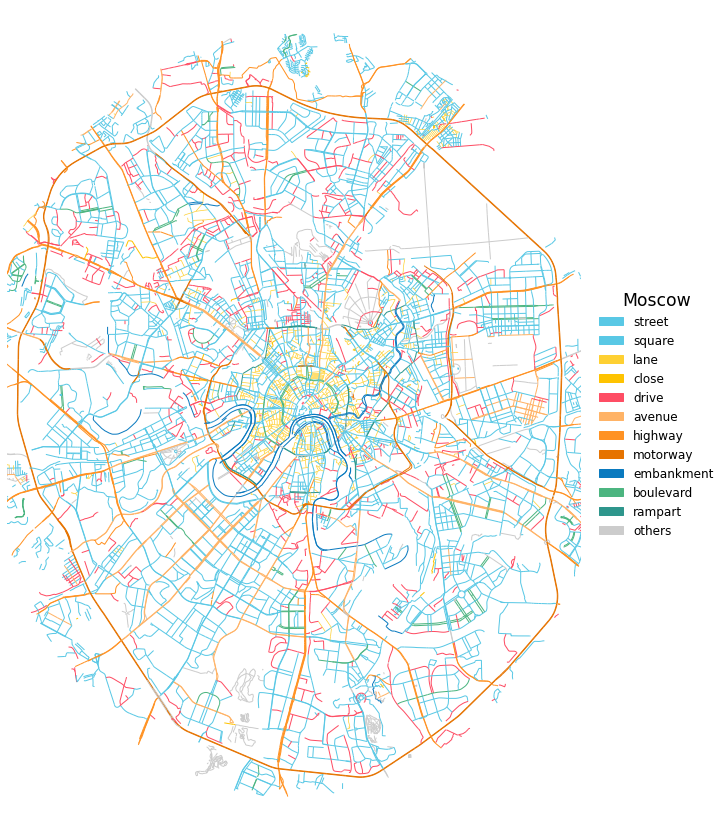

In [ ]:
plot_and_save(top,
              bottom,
              left,
              right,
              1,
              0.7,
              'Moscow',
              (1.25, 0.5),
              'images/moscow_english.png',
              True)

Create zoomed in map of city center

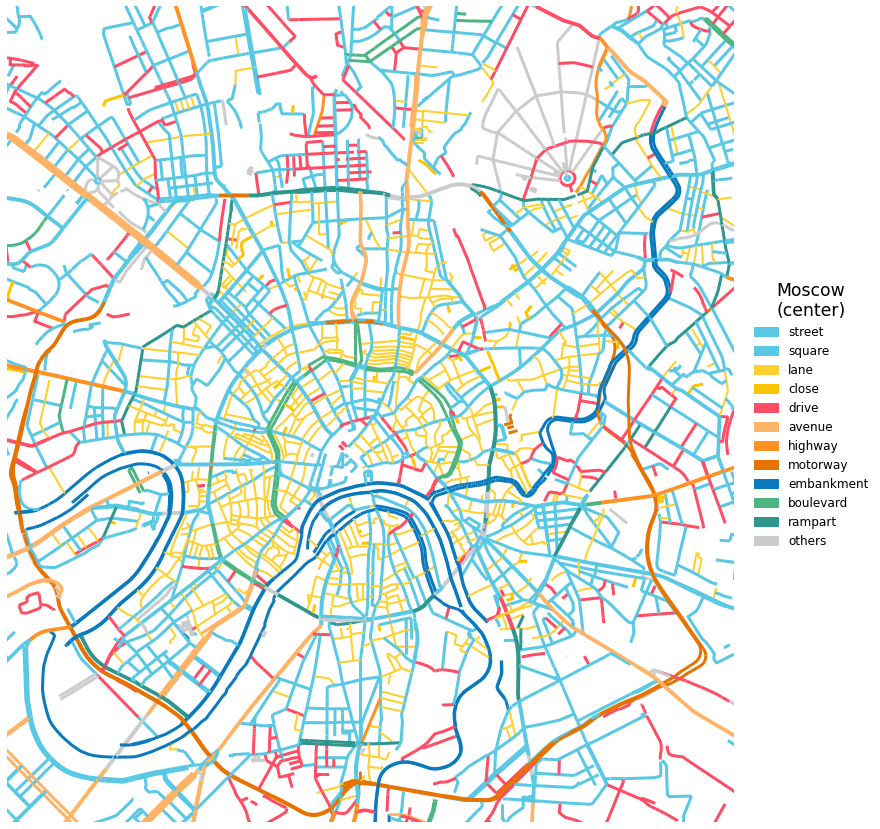

In [ ]:
top_center = 55.82
bottom_center = 55.70
left_center = 37.53
right_center = 37.72

plot_and_save(top_center,
             bottom_center,
             left_center,
             right_center,
             3,
             2.1,
             'Moscow\n(center)',
             (1.2, 0.5),
             'images/moscow_center_english.png',
             True)

Create interactive map with Folium

In [ ]:
# streets_map = folium.Map(location=center, zoom_start=10, tiles='CartoDB positron')

# for i, street in moscow.iterrows():
#     weight = 2
#     if 'переулок' in street['name']:
#         weight = 1    
#     folium.PolyLine(
#         [c[::-1] for c in street.geometry.coords],
#         color=colors[street['designation']],
#         popup=street['name'],
#         weight=weight
#         ).add_to(streets_map)

# streets_map.save('moscow/index.html')